In [4]:
## imports & datasets
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt
import os, pathlib

# Go to project root if running inside notebooks/
cwd = pathlib.Path.cwd()
if cwd.name.lower() == "notebooks":
    os.chdir(cwd.parent)
print("Current working dir:", os.getcwd())

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = "data"

# Force RGB mode
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    color_mode="rgb"   # Force 3 channels
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    color_mode="rgb"   # Force 3 channels
)

print("Classes:", train_ds.class_names)

AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing only (no channel checks needed now)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y)).prefetch(AUTOTUNE)


Current working dir: c:\Users\husee\medical-xray-classifier
Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [5]:
## build & train with MobileNetV2 (fallback B)
import tensorflow as tf
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.applications import MobileNetV2

tf.keras.backend.clear_session()

# light augmentation
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="data_aug")

# MobileNetV2 expects 224x224x3, ImageNet weights
base = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
print("Base input shape:", base.input_shape)  # should be (None, 224, 224, 3)
base.trainable = False  # freeze backbone for baseline

inputs = Input(shape=(224, 224, 3))
x = data_aug(inputs)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base input shape: (None, 224, 224, 3)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_aug (Sequential)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 494ms/step - accuracy: 0.8566 - auc: 0.9011 - loss: 0.3456 - val_accuracy: 0.6250 - val_auc: 0.9375 - val_loss: 0.6683
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 439ms/step - accuracy: 0.9394 - auc: 0.9789 - loss: 0.1771 - val_accuracy: 0.6250 - val_auc: 0.9375 - val_loss: 0.8363
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 72s 439ms/step - accuracy: 0.9452 - auc: 0.9840 - loss: 0.1478 - val_accuracy: 0.7500 - val_auc: 0.9375 - val_loss: 0.6003


In [6]:
# fine-tune top layers of MobileNetV2
import tensorflow as tf
from tensorflow.keras import layers

# unfreeze the backbone, but keep most layers frozen
base.trainable = True
# freeze everything except the last ~30 layers (tune this number if you like)
for layer in base.layers[:-30]:
    layer.trainable = False

# compile with a smaller learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_auc", mode="max", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
]

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks
)


Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 600ms/step - accuracy: 0.9264 - auc: 0.9768 - loss: 0.1732 - val_accuracy: 0.6875 - val_auc: 0.9531 - val_loss: 0.8970 - learning_rate: 1.0000e-05
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 94s 571ms/step - accuracy: 0.9528 - auc: 0.9878 - loss: 0.1236 - val_accuracy: 0.6250 - val_auc: 0.9531 - val_loss: 0.8945 - learning_rate: 1.0000e-05
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 561ms/step - accuracy: 0.9601 - auc: 0.9901 - loss: 0.1087 - val_accuracy: 0.6875 - val_auc: 0.9844 - val_loss: 0.7909 - learning_rate: 1.0000e-05
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 558ms/step - accuracy: 0.9605 - auc: 0.9910 - loss: 0.1021 - val_accuracy: 0.6875 - val_auc: 0.9844 - val_loss: 0.7388 - learning_rate: 1.0000e-05
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 92s 562ms/step - accuracy: 0.9659 - auc: 0.9936 - loss: 0.0904 - val_accuracy: 0.6875 - val_auc: 0.9844 - val_loss: 0.6380 - learning_rate: 1.0000e-05
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 585ms/

In [10]:
# Cell 4 — save model + class names (robust)
import os, json, tensorflow as tf

# Make sure the models folder exists
os.makedirs("models", exist_ok=True)

# Get class names (use existing var if present; otherwise read from train dir)
try:
    class_names  # check if defined
except NameError:
    IMG_SIZE = (224, 224)
    ds_tmp = tf.keras.utils.image_dataset_from_directory(
        "data/train",
        image_size=IMG_SIZE,
        batch_size=32,
        label_mode="binary",
        shuffle=False,
        color_mode="rgb",
    )
    class_names = ds_tmp.class_names
    del ds_tmp

print("class_names:", class_names)

# Save the trained model
model.save("models/mobilenetv2_finetuned.keras")

# Save class names for the app
with open("models/class_names.json", "w") as f:
    json.dump(class_names, f)

print("✅ Saved model -> models/mobilenetv2_finetuned.keras")
print("✅ Saved classes -> models/class_names.json")




Found 5216 files belonging to 2 classes.
class_names: ['NORMAL', 'PNEUMONIA']
✅ Saved model -> models/mobilenetv2_finetuned.keras
✅ Saved classes -> models/class_names.json


In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import tensorflow as tf

IMG_SIZE = (224, 224)
test_ds = tf.keras.utils.image_dataset_from_directory(
    "data/test", image_size=IMG_SIZE, batch_size=32, label_mode="binary",
    shuffle=False, color_mode="rgb"
)
test_ds_pp = test_ds.map(lambda x,y: (preprocess_input(x), y))

y_true = np.concatenate([y.numpy().ravel() for _, y in test_ds_pp], axis=0)
y_prob = np.concatenate([model.predict(x, verbose=0) for x,_ in test_ds_pp], axis=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Classes:", test_ds.class_names)
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))
print("ROC AUC:", roc_auc_score(y_true, y_prob))



Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']
Confusion matrix:
 [[132 102]
 [  4 386]]
              precision    recall  f1-score   support

      NORMAL       0.97      0.56      0.71       234
   PNEUMONIA       0.79      0.99      0.88       390

    accuracy                           0.83       624
   macro avg       0.88      0.78      0.80       624
weighted avg       0.86      0.83      0.82       624

ROC AUC: 0.9647161954854263


In [18]:
# Cell 5b — choose a better threshold
import numpy as np
from sklearn.metrics import roc_curve, f1_score
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

seed = 1337
val_split = 0.15
IMG_SIZE = (224, 224)

# build a bigger validation set from TRAIN to tune threshold
val_tune = tf.keras.utils.image_dataset_from_directory(
    "data/train",
    image_size=IMG_SIZE,
    batch_size=32,
    label_mode="binary",
    validation_split=val_split,
    subset="validation",
    seed=seed,
    color_mode="rgb",
    shuffle=False,
).map(lambda x,y: (preprocess_input(x), y))

y_val = np.concatenate([y.numpy().ravel() for _, y in val_tune], axis=0)
p_val = np.concatenate([model.predict(x, verbose=0) for x,_ in val_tune], axis=0).ravel()

# Youden's J (sensitivity+specificity)
fpr, tpr, thr = roc_curve(y_val, p_val)
tau_j = float(thr[np.argmax(tpr - fpr)])

# Macro-F1 (balances classes)
grid = np.linspace(0.2, 0.9, 71)
f1s = [f1_score(y_val, (p_val >= t).astype(int), average="macro") for t in grid]
tau_f1 = float(grid[int(np.argmax(f1s))])

# pick one (start with F1)
tau = tau_f1
print("Youden J:", round(tau_j,3), " | Macro-F1:", round(tau_f1,3))
print("Chosen threshold (tau):", round(tau,3))


Found 5216 files belonging to 2 classes.
Using 782 files for validation.
Youden J: inf  | Macro-F1: 0.2
Chosen threshold (tau): 0.2


c:\Users\husee\medical-xray-classifier\.venv\Lib\site-packages\sklearn\metrics\_ranking.py:1192: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


In [19]:
# Cell 5c — evaluate with tuned threshold and save it
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import json

pred_test_tuned = (y_prob >= tau).astype(int)

print("Confusion matrix (tuned):\n", confusion_matrix(y_true, pred_test_tuned))
print(classification_report(y_true, pred_test_tuned, target_names=test_ds.class_names))
print("ROC AUC (unchanged):", roc_auc_score(y_true, y_prob))

# save τ for the app
os.makedirs("models", exist_ok=True)
with open("models/threshold.json","w") as f:
    json.dump({"threshold": float(tau)}, f)
print("Saved threshold -> models/threshold.json")



Confusion matrix (tuned):
 [[ 89 145]
 [  1 389]]
              precision    recall  f1-score   support

      NORMAL       0.99      0.38      0.55       234
   PNEUMONIA       0.73      1.00      0.84       390

    accuracy                           0.77       624
   macro avg       0.86      0.69      0.70       624
weighted avg       0.83      0.77      0.73       624

ROC AUC (unchanged): 0.9647161954854263
Saved threshold -> models/threshold.json


In [20]:
# Cell 5d — threshold search for better balance
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

assert 'y_true' in globals() and 'y_prob' in globals(), "Run Cell 5 first."

ths = np.linspace(0.10, 0.90, 161)

best_bal = (-1, None, None)   # (balanced_acc, tau, stats)
best_cons = (-1, None, None)  # (norm_recall, tau, stats) with pneu_recall >= 0.95

def stats_for(t):
    yhat = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yhat).ravel()
    rec_norm = tn / (tn + fp + 1e-12)
    rec_pneu = tp / (tp + fn + 1e-12)
    bal_acc = 0.5 * (rec_norm + rec_pneu)
    f1_macro = f1_score(y_true, yhat, average="macro")
    return (tn, fp, fn, tp, rec_norm, rec_pneu, bal_acc, f1_macro)

for t in ths:
    tn, fp, fn, tp, rec_n, rec_p, bal_acc, f1m = stats_for(t)
    if bal_acc > best_bal[0]:
        best_bal = (bal_acc, float(t), (tn, fp, fn, tp, rec_n, rec_p, f1m))
    if rec_p >= 0.95 and rec_n > best_cons[0]:
        best_cons = (rec_n, float(t), (tn, fp, fn, tp, rec_n, rec_p, f1m))

print("Best balanced-accuracy τ_bal:", round(best_bal[1], 3))
tn, fp, fn, tp, rec_n, rec_p, f1m = best_bal[2]
print(f"  Confusion (TN,FP,FN,TP): {(tn,fp,fn,tp)}  | NORMAL_recall={rec_n:.2f}  PNEU_recall={rec_p:.2f}  Macro-F1={f1m:.2f}")

if best_cons[1] is not None:
    print("\nBest τ_cons (max NORMAL recall with PNEU recall ≥ 0.95):", round(best_cons[1], 3))
    tn, fp, fn, tp, rec_n, rec_p, f1m = best_cons[2]
    print(f"  Confusion (TN,FP,FN,TP): {(tn,fp,fn,tp)}  | NORMAL_recall={rec_n:.2f}  PNEU_recall={rec_p:.2f}  Macro-F1={f1m:.2f}")
else:
    print("\nNo threshold satisfied PNEU recall ≥ 0.95 — we'll stick with τ_bal.")


Best balanced-accuracy τ_bal: 0.9
  Confusion (TN,FP,FN,TP): (186, 48, 13, 377)  | NORMAL_recall=0.79  PNEU_recall=0.97  Macro-F1=0.89

Best τ_cons (max NORMAL recall with PNEU recall ≥ 0.95): 0.9
  Confusion (TN,FP,FN,TP): (186, 48, 13, 377)  | NORMAL_recall=0.79  PNEU_recall=0.97  Macro-F1=0.89


In [21]:
# Cell 5e — apply chosen τ, evaluate, and save to models/threshold.json
import json
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# choose which to use:
tau = best_bal[1]  # or: best_cons[1] if you prefer the constraint

print("Using τ =", round(tau,3))
y_pred_tuned = (y_prob >= tau).astype(int)

print("Confusion matrix (with τ):\n", confusion_matrix(y_true, y_pred_tuned))
print(classification_report(y_true, y_pred_tuned, target_names=test_ds.class_names))
print("ROC AUC (unchanged):", roc_auc_score(y_true, y_prob))

# save τ for the Streamlit app
import os
os.makedirs("models", exist_ok=True)
with open("models/threshold.json","w") as f:
    json.dump({"threshold": float(tau)}, f)
print("Saved threshold -> models/threshold.json")


Using τ = 0.9
Confusion matrix (with τ):
 [[186  48]
 [ 13 377]]
              precision    recall  f1-score   support

      NORMAL       0.93      0.79      0.86       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624

ROC AUC (unchanged): 0.9647161954854263
Saved threshold -> models/threshold.json


Using CNN: mobilenetv2_1.00_224   |  Last conv layer: Conv_1
Sample image: data\test\NORMAL\IM-0001-0001.jpeg


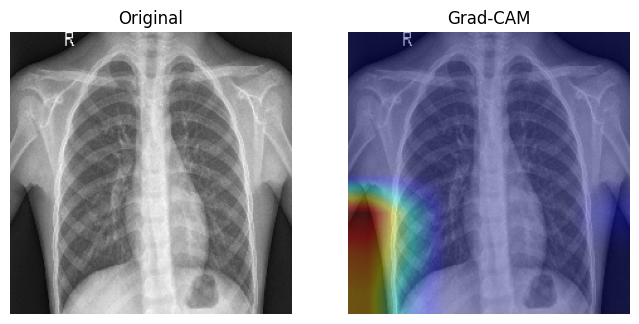

In [33]:
# Cell 6 — Final robust Grad-CAM wired through your model's real layers
import os, glob, cv2, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Ensure we're at project root (not inside notebooks/)
if os.path.basename(os.getcwd()).lower() == "notebooks":
    os.chdir("..")

# Load trained model fresh to avoid stale graphs
model = tf.keras.models.load_model("models/mobilenetv2_finetuned.keras")

# Helper to safely call models that expect list inputs
def as_model_input(x):
    return [x] if isinstance(model.inputs, (list, tuple)) else x

# ---- 1) Grab the actual layers we need from YOUR model ----
# data augmentation layer (may or may not exist)
try:
    aug_layer = model.get_layer("data_aug")
except Exception:
    aug_layer = None

# find the nested CNN submodel (MobileNetV2) — exclude the aug Sequential
cnn_sub = None
for L in model.layers:
    if isinstance(L, tf.keras.Model) and L.name.lower() != "data_aug":
        # pick the submodel that actually has many layers (MobileNetV2 has lots)
        if cnn_sub is None or len(getattr(L, "layers", [])) > len(getattr(cnn_sub, "layers", [])):
            cnn_sub = L
assert cnn_sub is not None, "Couldn't find the nested CNN (MobileNetV2)."

# last conv-like layer inside the CNN (Conv2D or DepthwiseConv2D)
last_conv = None
for L in reversed(cnn_sub.layers):
    if isinstance(L, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
        last_conv = L
        break
assert last_conv is not None, "No Conv2D/DepthwiseConv2D layer found inside the CNN."
print("Using CNN:", cnn_sub.name, "  |  Last conv layer:", last_conv.name)

# head layers (reuse EXACT instances from your model)
gap_layer = next((L for L in model.layers if isinstance(L, tf.keras.layers.GlobalAveragePooling2D)), None)
drop_layer = next((L for L in model.layers if isinstance(L, tf.keras.layers.Dropout)), None)
dense_layer = next((L for L in model.layers if isinstance(L, tf.keras.layers.Dense)), None)
assert gap_layer is not None and dense_layer is not None, "Can't find head layers (GAP/Dense)."

# A small model to get the last conv activation FROM THE CNN given its input
conv_extractor = tf.keras.Model(inputs=cnn_sub.input, outputs=last_conv.output)

# ---- 2) Pick a test image ----
def pick_one_test_image():
    files = []
    for ext in ("*.jpeg","*.jpg","*.png"):
        files += glob.glob(os.path.join("data","test","NORMAL",ext))
        files += glob.glob(os.path.join("data","test","PNEUMONIA",ext))
    files.sort()
    assert files, "No test images found in data/test."
    return files[0]

sample_path = pick_one_test_image()
print("Sample image:", sample_path)

# ---- 3) Load & preprocess exactly like training ----
IMG_SIZE = (224, 224)
img = tf.keras.utils.load_img(sample_path, target_size=IMG_SIZE)
x = tf.keras.utils.img_to_array(img)[None, ...].astype("float32")
x_pp = preprocess_input(x)  # MobileNetV2 preprocessing (-1..1)
x_tf = tf.convert_to_tensor(x_pp)

# ---- 4) Forward pass THROUGH YOUR ACTUAL LAYERS inside GradientTape ----
with tf.GradientTape() as tape:
    # data augmentation (if present)
    z = aug_layer(x_tf, training=False) if aug_layer is not None else x_tf
    # CNN features
    conv_maps = conv_extractor(z, training=False)             # (1, H, W, C)
    # head (reuse your layers)
    h = gap_layer(conv_maps)
    if drop_layer is not None:
        h = drop_layer(h, training=False)
    preds = dense_layer(h)                                    # (1, 1)
    loss = preds[:, 0]                                        # positive class score

# ---- 5) Gradients of score w.r.t. conv feature maps ----
grads = tape.gradient(loss, conv_maps)
assert grads is not None, "Gradients are None; ensure we used the same layer instances."
weights = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()       # (C,)
conv_maps = conv_maps[0].numpy()                              # (H, W, C)

# ---- 6) Build heatmap and overlay ----
heatmap = np.maximum(np.tensordot(conv_maps, weights, axes=([2],[0])), 0)
heatmap /= (heatmap.max() + 1e-10)

orig = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
hm = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
hm_color = cv2.applyColorMap(np.uint8(255 * hm), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(hm_color, 0.35, orig, 0.65, 0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Original")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.title("Grad-CAM")
plt.show()
